In [123]:
import io, os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import platform
import sys
from glob import glob
from collections import Counter
import pyspark.sql

pd.set_option("display.max_columns", None)

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [183]:
year = 2022
month = "03"

def is_databricks():
    return True if "DATABRICKS_RUNTIME_VERSION" in os.environ else False

# for generating alternate test sets
def is_alt_test():
    return False


running_on = platform.system()

if running_on == "Windows":
    path = fr"C:\Users\\pmm\\ownCloud\\jupyter\\22-05 HR"
elif running_on == "Darwin":
    path = f"/Users/pmm/ownCloud/jupyter/22-05 HR"
elif "google.colab" in str(get_ipython()):
    path = "/content"
elif is_databricks():
    my_container = "projects"
    my_lake = "tdsdsdatalake"
    mount_point = f"/mnt/{my_container}"
    path = f"{mount_point}"

    configs = {
        "fs.azure.account.auth.type": "CustomAccessToken",
        "fs.azure.account.custom.token.provider.class": spark.conf.get(
            "spark.databricks.passthrough.adls.gen2.tokenProviderClassName"
        ),
    }

    if not any(
        mount.mountPoint == mount_point for mount in dbutils.fs.mounts()
    ):
        dbutils.fs.mount(
            source=f"abfss://{my_container}@{my_lake}.dfs.core.windows.net/",
            mount_point=mount_point,
            extra_configs=configs,
        )


# data_file = os.path.join(path, "Internal Movement for DS FINAL.csv")


In [125]:
if is_databricks():
    data_file = os.path.join(path, "Internal Movement for DS FINAL.csv")
    df_orig = (
        spark.read.option("header", "true")
        .option("inferSchema", "true")
        .csv(data_file)
        .select("*")
        .toPandas()
    )
else:
    data_file = os.path.join(path, "Internal Movement for DS FINAL.xlsx")
    df_orig = pd.read_excel(os.path.join(data_file))

In [126]:
dtypes = {
    "pers_no": "object",
    "job_key": "object",
    "position": "object",
    "job_abbrev": "object",
    "contract": "object",
    "act": "object",
    "reason": "int64",
    "start_date": "datetime64[ns]",
    "most_recent_hire_date_01": "datetime64[ns]",
    "service_anniversary_16": "datetime64[ns]",
    "cocd": "object",
    "org_unit": "object",
    "employee_group": "object",
    "employee_subgroup": "object",
    "commission_type": "object",
    "pay_scale_group_effective_date": "datetime64[ns]",
    "ps_group": "object",
    "prev_ps_group": "object",
    "annl_sal_hrly_wage": "float64",
    "annual_salary": "float64",
    "pay_level_midpoint": "float64",
    "prev_wage": "float64",
    "pts": "int64",
    "supervisor": "object",
    "ps_area": "object",
    "aap": "object",
    "city": "object",
    "state": "object",
    "generation": "object",
    "retiree_medical_eligibility": "object",
    "functional_area": "object",
    "fst": "object",
    "age_at_action": "float64",
    "percent_of_market_after_action": "float64",
    "percent_of_market_before_action": "float64",
    "hired": "object",
    "term": "object",
    "retirement": "object",
    "promotion": "object",
    "progression": "object",
    "previous_job_code": "object",
    "current_bu": "object",
    "previous_bu": "object",
    "gender_most_current": "object",
    "race_ethinicity_most_current": "object",
    "poc_non_poc_most_current": "object",
    "tds_vet_excludes_v1_v9_most_current": "object",
    "disabled_most_current": "object",
    "tds_vet_excludes_v1_v9_most_current": "object",
}

In [127]:
df = df_orig.copy()
df.columns = (
    df.columns.str.lower()
    .str.replace("^\s", "", regex=True)
    .str.replace("[\s.]", "_", regex=True)
    .str.replace("[^0-9a-zA-Z]", "_", regex=True)
    .str.replace("_+", "_", regex=True)
    .str.replace("_$", "", regex=True)
)

df = df.astype(dtypes)

In [128]:
df = df.sort_values(
    by=["pers_no", "start_date"], ascending=False, ignore_index=True
)

In [129]:
# ZA = new hire
# ZB - rehire

cond = ((df["act"] == "ZA") | (df["act"] == "ZB")) & (df["reason"] == 1)

df["previous_job_code"] = np.where(cond, 0, df["previous_job_code"])
df["previous_bu"] = np.where(cond, "NEW HIRE", df["previous_bu"])
df["prev_ps_group"] = np.where(cond, "NEW HIRE", df["prev_ps_group"])

In [130]:
# rows with na for supervisor where supervisor is the same value in row prior and after
df["pers_no_before"] = df["pers_no"].shift(1)
df["pers_no_after"] = df["pers_no"].shift(-1)
df["supervisor_before"] = df["supervisor"].shift(1)
df["supervisor_after"] = df["supervisor"].shift(-1)

df["supervisor"] = np.where(
    (
        (df["supervisor"].isnull())
        & (df["pers_no_before"] == df["pers_no_after"])
        & (df["supervisor_before"] == df["supervisor_after"])
    ),
    df["supervisor_before"],
    df["supervisor"],
)

df = df.drop(
    columns=[
        "pers_no_before",
        "pers_no_after",
        "supervisor_before",
        "supervisor_after",
    ]
)

In [131]:
# Male = 0
# Female = 1
# No non-binary in this dataset
df["gender"] = np.where((df["gender_most_current"] == "Male"), 0, np.nan)
df["gender"] = np.where(
    (df["gender_most_current"] == "Female"), 1, df["gender"]
)

assert df["gender"].isnull().sum() == 0  # no non-binary in dataset

In [132]:
# Non-Exempt Hourly = 0
# Exempt Salaried = 1
df["emp_subgroup"] = np.where(
    (df["employee_subgroup"] == "Non-Exempt Hourly"), 0, np.nan
)
df["emp_subgroup"] = np.where(
    (df["employee_subgroup"] == "Exempt Salaried"), 1, df["emp_subgroup"]
)

assert df["emp_subgroup"].isnull().sum() == 0

In [133]:
# NC = 0
# CO = 1
df["commission"] = np.where((df["commission_type"] == "NC"), 0, np.nan)
df["commission"] = np.where(
    (df["commission_type"] == "CO"), 1, df["commission"]
)

assert df["commission"].isnull().sum() == 0

In [134]:
assert df["fst"].isnull().sum() == 0
df["fst_bool"] = np.where((df["fst"] == "Yes"), 1, 0)

In [135]:
assert df["urg_most_current"].isnull().sum() == 0
df["urg_current"] = np.where((df["urg_most_current"] == "Yes"), 1, 0)

In [136]:
# X or NaN
df["retiree_med"] = np.where((df["retiree_medical_eligibility"] == "X"), 1, 0)

In [137]:
# x or NaN
df["progression_bool"] = np.where((df["progression"] == "x"), 1, 0)

In [138]:
# x or NaN
df["promotion_bool"] = np.where((df["promotion"] == "x"), 1, 0)

In [139]:
# x or NaN
df["retirement_bool"] = np.where((df["retirement"] == "x"), 1, 0)

In [140]:
# x or NaN
df["term_bool"] = np.where((df["term"] == "x"), 1, 0)

In [141]:
# x or NaN
df["hired_bool"] = np.where((df["hired"] == "x"), 1, 0)

In [142]:
# Drop cols we converted to bools
df = df.drop(
    columns=[
        "gender_most_current",
        "employee_subgroup",
        "commission_type",
        "fst",
        "urg_most_current",
        "retiree_medical_eligibility",
        "progression",
        "promotion",
        "retirement",
        "term",
        "hired",
    ]
)

In [143]:
# #feature engineering - check that variables are calculated correctly
# #number of years at TDS
df["Time_In_TDS"] = (
    datetime.now() - df.most_recent_hire_date_01
) / np.timedelta64(1, "Y")

In [144]:
# #number of years on team
# df["Time_In_Team"] = (datetime.now() - df.start_date) / np.timedelta64(1, "Y")

In [145]:
# #number of years in payscale
df["Time_In_Payscale"] = (
    datetime.now() - df.pay_scale_group_effective_date
) / np.timedelta64(1, "Y")

In [146]:
# uncontrollable churn == 0
uncontrollable = [16, 23, 32, 36, 37, 47]
mask = (df["act"] == "ZI") & (~df["reason"].isin(uncontrollable))
df["churned"] = np.where(mask, 1, 0)

In [147]:
df[["prev_pers_no", "prev_start_date", "prev_annual_salary"]] = df[
    ["pers_no", "start_date", "annual_salary"]
].shift(-1)

df["time_since_last_event"] = np.where(
    (df["pers_no"] == df["prev_pers_no"]),
    (df["start_date"] - df["prev_start_date"]) / np.timedelta64(1, "Y"),
    0,
)

df["annual_salary"] = np.where(
    (df["pers_no"] == df["prev_pers_no"]) & (df["churned"] == 1),
    df["prev_annual_salary"],
    df["annual_salary"],
)

df["percent_of_market_after_action"] = np.where(
    df["churned"] == 1,
    df["percent_of_market_before_action"],
    df["percent_of_market_after_action"],
)

df = df.drop(columns=["prev_pers_no", "prev_start_date", "prev_annual_salary"])

In [148]:
print(f"Distribution of target feature\n{df['churned'].value_counts()}")

Distribution of target feature
0    22032
1      831
Name: churned, dtype: int64


In [149]:
# print(
#     f"Number of rows: {df.shape[0]};  Number of columns: {df.shape[1]}; No of missing values: {sum(df.isnull().sum())}"
# )

In [150]:
num_nans = (
    df.loc[:, (df.isnull().sum() > 0)]
    .isnull()
    .sum()
    .sort_values(ascending=False)
)

if len(num_nans) > 0:
    print("Number of misssing values by feature (nonzero)")
    num_nans.to_frame(name="NaNs").style.set_properties(
        **{
            "background-color": "white",
            "color": "darkred",
            "border-color": "dark",
        }
    )
else:
    print("No missing values in data")

Number of misssing values by feature (nonzero)


,NaNs
percent_of_market_after_action,1481
percent_of_market_before_action,1481
supervisor,543
prev_ps_group,451
aap,22
previous_job_code,13
previous_bu,7


In [151]:
# print("Info about the data types:")
# dict(Counter(df.dtypes.values))

In [152]:
frac = 1
# df.sample(frac=frac, axis=1).describe().T

df.sample(frac=frac, axis=1).describe().T.style.bar(
    subset=["mean"], color="lightblue"
).background_gradient(subset=["std"], cmap="Reds").background_gradient(
    subset=["50%"], cmap="coolwarm"
)

,count,mean,std,min,25%,50%,75%,max
time_since_last_event,22863.000000,0.281922,0.301702,0.000000,0.035593,0.191653,0.446279,1.848087
term_bool,22863.000000,0.048856,0.215572,0.000000,0.000000,0.000000,0.000000,1.000000
percent_of_market_before_action,21382.000000,3.092792,74.764903,0.000000,0.781836,0.856259,0.957252,3695.358269
churned,22863.000000,0.036347,0.187156,0.000000,0.000000,0.000000,0.000000,1.000000
prev_wage,22863.000000,33476.981897,44520.064330,0.000000,18.615000,28.500000,68940.000000,662500.000000
Time_In_Payscale,22863.000000,4.383750,4.781020,0.182808,1.614733,2.534670,4.604527,21.352305
emp_subgroup,22863.000000,0.477540,0.499506,0.000000,0.000000,0.000000,1.000000,1.000000
fst_bool,22863.000000,0.238201,0.425992,0.000000,0.000000,0.000000,0.000000,1.000000
pts,22863.000000,3.042602,1.346764,0.000000,3.000000,3.000000,4.000000,5.000000
progression_bool,22863.000000,0.025412,0.157377,0.000000,0.000000,0.000000,0.000000,1.000000


In [153]:
# df.var()

In [154]:
# Move churned to first column
df = df[["churned"] + [col for col in df.columns if col != "churned"]]

In [169]:
corr_matrix = df.corr(method="pearson", min_periods=1)
corr_matrix

,churned,reason,annual_salary,prev_wage,pts,age_at_action,percent_of_market_after_action,percent_of_market_before_action,gender,emp_subgroup,commission,fst_bool,urg_current,retiree_med,progression_bool,promotion_bool,hired_bool,Time_In_TDS,Time_In_Payscale
churned,1.000000,0.269547,-0.098191,-0.042296,-0.154384,-0.012685,-0.082419,-0.005660,-0.000196,-0.029621,0.060704,0.010110,0.018687,0.002675,-0.030866,-0.042285,-0.043661,-0.068042,-0.025223
reason,0.269547,1.000000,-0.021674,0.069531,0.042960,0.096678,-0.123326,-0.019278,0.001008,0.059638,0.111798,-0.021205,-0.000951,0.069961,-0.142597,-0.227799,-0.235208,0.066221,0.095314
annual_salary,-0.098191,-0.021674,1.000000,0.828899,0.359459,0.257257,0.551838,-0.011136,-0.072238,0.539186,-0.309622,-0.162656,-0.123631,0.225012,0.004392,0.016663,-0.141403,0.480131,0.290890
prev_wage,-0.042296,0.069531,0.828899,1.000000,0.312577,0.171267,0.224764,0.017971,0.008372,0.809015,-0.111292,-0.461781,-0.040577,0.117567,-0.013322,-0.028816,-0.197313,0.368357,0.181892
pts,-0.154384,0.042960,0.359459,0.312577,1.000000,0.156300,0.269494,0.008642,0.016429,0.162124,-0.104902,-0.048028,-0.040990,0.110960,0.034280,0.051045,-0.540661,0.312784,0.184886
age_at_action,-0.012685,0.096678,0.257257,0.171267,0.156300,1.000000,0.163829,0.014885,0.102788,0.069296,-0.011151,-0.017494,0.031002,0.528824,-0.080108,-0.067103,-0.117223,0.524620,0.424200
percent_of_market_after_action,-0.082419,-0.123326,0.551838,0.224764,0.269494,0.163829,1.000000,0.022308,-0.003131,-0.084667,-0.581445,0.132908,-0.040548,0.222134,0.005711,-0.030438,-0.116931,0.365340,0.313764
percent_of_market_before_action,-0.005660,-0.019278,-0.011136,0.017971,0.008642,0.014885,0.022308,1.000000,-0.015796,-0.031798,-0.007554,0.018432,-0.017868,0.018382,-0.005165,-0.007602,-0.009868,0.004499,-0.020158
gender,-0.000196,0.001008,-0.072238,0.008372,0.016429,0.102788,-0.003131,-0.015796,1.000000,0.027420,0.099341,-0.344149,0.816364,0.015520,-0.064805,-0.031449,-0.014640,0.047344,0.002096
emp_subgroup,-0.029621,0.059638,0.539186,0.809015,0.162124,0.069296,-0.084667,-0.031798,0.027420,1.000000,0.116893,-0.571041,-0.005595,0.003751,-0.018992,0.035778,-0.081449,0.179546,0.026803


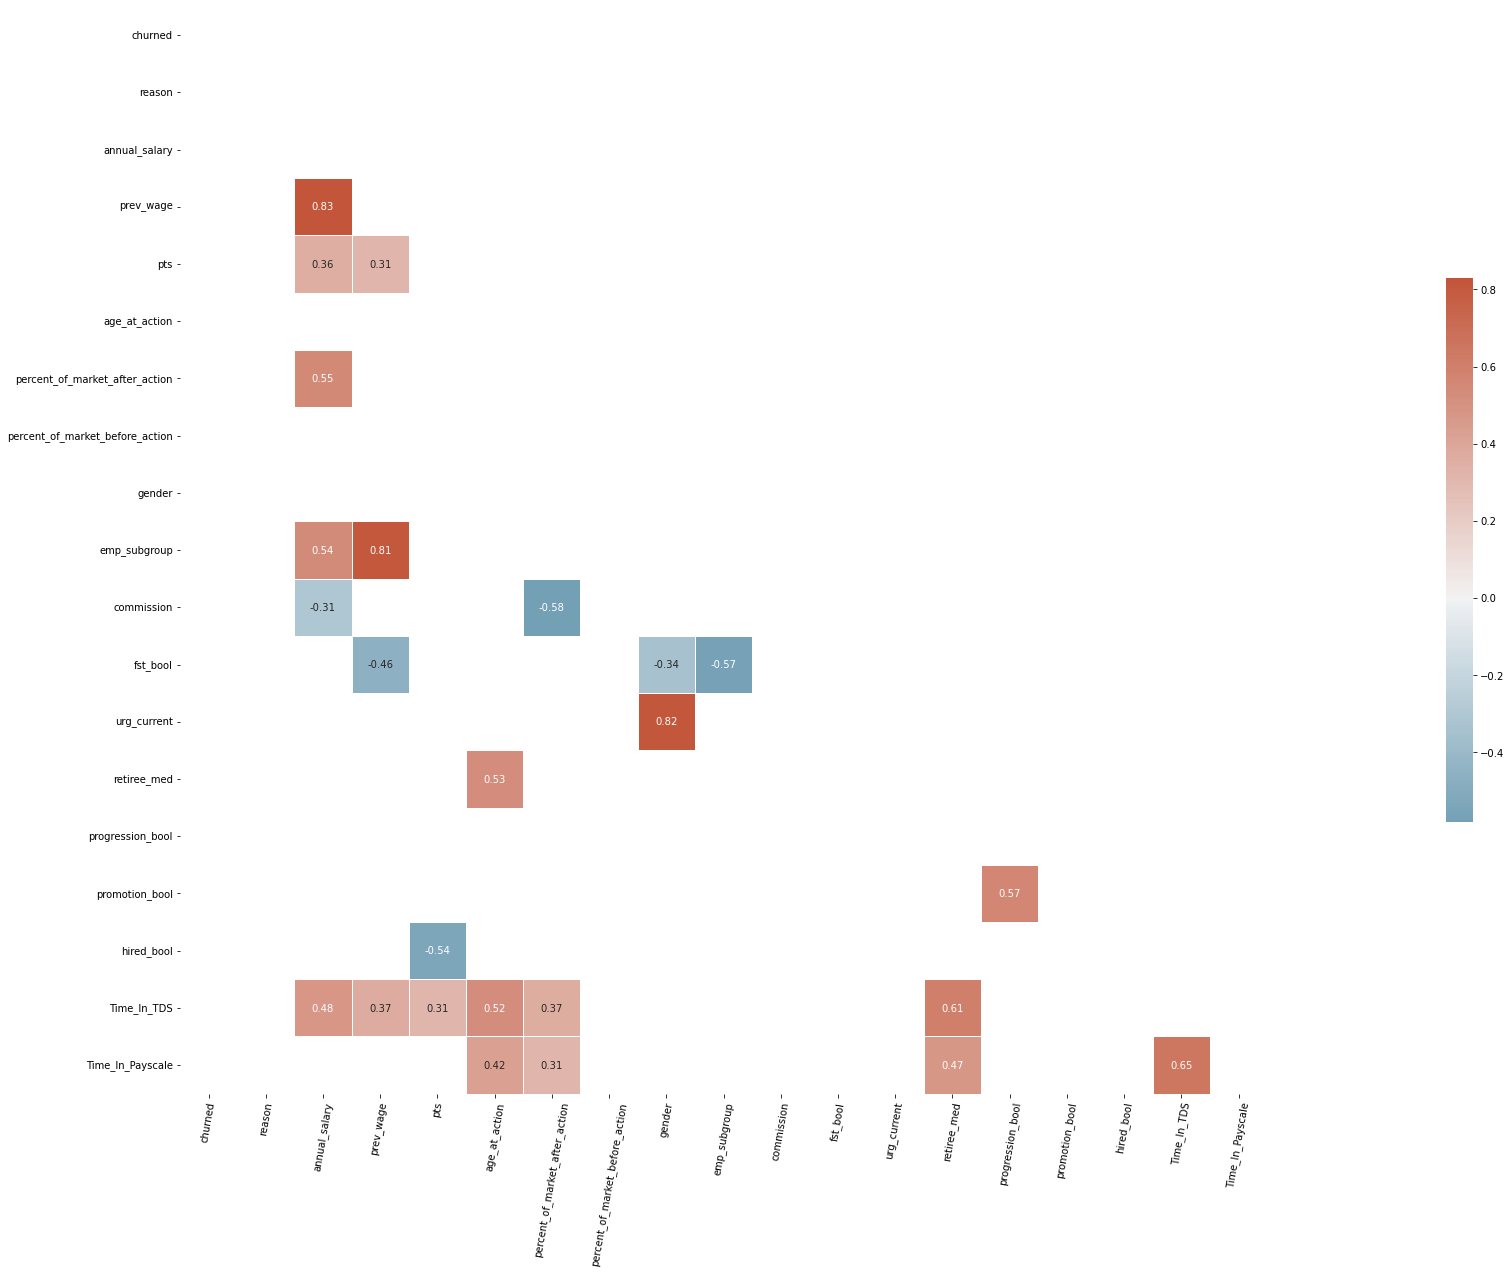

In [170]:
_ = plt.figure(figsize=(64, 20))

filtered = corr_matrix[
    ((corr_matrix >= 0.3) | (corr_matrix <= -0.3)) & (corr_matrix != 1)
]

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
# f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

g = sns.heatmap(
    filtered,
    # corr_matrix,
    mask=mask,
    cmap=cmap,
    # vmax=0.3,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,
)

_ = g.set_xticklabels(g.get_xticklabels(), rotation=80)

In [157]:
# drop unnecessary & leaky features
df = df.drop(
    columns=[
        "annl_sal_hrly_wage",
        "pay_level_midpoint",
        "generation",
        # "act",
        # "reason",
        "employee_group",
        "retirement_bool",
        "term_bool",
        # "percent_of_market_before_action",
        "time_since_last_event",
        # "Time_In_Team",
        "prev_wage",
    ]
)

if not is_alt_test():
    df = df.drop(columns=["act", "reason", "percent_of_market_before_action",])

In [159]:
df = df.dropna()

In [165]:
assert df["churned"].value_counts()[1] == 667

In [160]:
if is_alt_test():
    if is_databricks():
        df["previous_job_code"] = df["previous_job_code"].astype(str)
        sdf = sqlContext.createDataFrame(df.reset_index(drop=True))
        sdf.write.mode("overwrite").parquet(f"{mount_point}/2022-05 HR/df_adj.parquet")
    else:
        df.reset_index(drop=True).to_parquet(os.path.join(path, "df_adj.parquet"))
else:
    if is_databricks():
        df["previous_job_code"] = df["previous_job_code"].astype(str)
        sdf = sqlContext.createDataFrame(df.reset_index(drop=True))
        sdf.write.mode("overwrite").parquet(f"{mount_point}/2022-05 HR/df.parquet")
    else:
        df.reset_index(drop=True).to_parquet(os.path.join(path, "df.parquet"))

In [171]:
df.columns

Index(['churned', 'pers_no', 'job_key', 'position', 'job_abbrev', 'contract',
       'act', 'reason', 'start_date', 'most_recent_hire_date_01',
       'service_anniversary_16', 'cocd', 'org_unit',
       'pay_scale_group_effective_date', 'ps_group', 'prev_ps_group',
       'annual_salary', 'prev_wage', 'pts', 'supervisor', 'ps_area', 'aap',
       'city', 'state', 'functional_area', 'age_at_action',
       'percent_of_market_after_action', 'percent_of_market_before_action',
       'previous_job_code', 'current_bu', 'previous_bu',
       'race_ethinicity_most_current', 'poc_non_poc_most_current',
       'disabled_most_current', 'tds_vet_excludes_v1_v9_most_current',
       'gender', 'emp_subgroup', 'commission', 'fst_bool', 'urg_current',
       'retiree_med', 'progression_bool', 'promotion_bool', 'hired_bool',
       'Time_In_TDS', 'Time_In_Payscale'],
      dtype='object')

In [172]:
53250*1.04


55380.0

In [173]:
55380/53250

1.04